In [135]:
import pickle
from Analysis_Utils import preprocessing_df as preprocessing
from Analysis_Utils import query_df
import DataStream_Vis_Utils as utils
import Classification_Utils as CU
import pandas as pd
import pdb
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Classification_Visualization import visualize_models
import numpy as np
import h5py
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder



# classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

# visualization
from yellowbrick.model_selection import CVScores
from yellowbrick.features import Rank2D
from Classification_Visualization import visualize_model, print_preds, plot_decision_tree
from yellowbrick.classifier import ClassificationReport
import seaborn as sns

# Ignore ipython warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib qt
%matplotlib inline

In [136]:
##############
# CLASSIFY (SCRIP ARG 4)
###############

In [227]:
def classify(model, X, Y, k):
    """
    Classifies trials as null vs not null.
    Args:
        model: sklearn model
        X_train (array): features, shape (num trials, num feat*num frames)
        hand_labels_y_train (array): labels shape (num trials)
        k (int): number of kfolds for cross validation score

    Returns:
        classifier_pipeline (pipeline): trained model
        predictions (array): classifier trial predictions
        score (int): mean of cross validation scores
    """
    # create pipeline
    classifier_pipeline = make_pipeline(preprocessing.StandardScaler(), model)

    # fit to training data
    classifier_pipeline.fit(X, Y)

    # calculate mean of kfold cv
    score = np.mean(cross_val_score(classifier_pipeline, X, Y, cv=k))

    # predict X_train data
    predictions = classifier_pipeline.predict(X)

    return classifier_pipeline, predictions, score


def remove_trials(X, Y, preds, toRemove):
    """
    Removes trials from labels after classification.
    Used to prepare data for next classification in hierarchy.
    Args:
        X (array): features, shape (num trials, num feat*num frames)
        Y (array): labels
        shape # type_labels_y_train, num_labels_y_train, hand_labels_y_train, tug_labels_y_train, switch_labels_y_train
        preds (array): classifier trial predictions
        toRemove: 0 to remove trials classified as 0, 1 otherwise

    Returns:
        X (array): filtered
        Y (array): filtered

    Notes:
        Preserves order of values
        Careful to remove values in X and corresponding Y labels for each class!
    """
    new_X = []
    new_Y = []
    trial_indices_X = len(X)
    # delete trials backwards
    # for each class of labels
    for y_arr in Y:
        i = trial_indices_X - 1
        new = []
        for _ in np.arange(trial_indices_X):
            if preds[i] != toRemove:
                new.append(y_arr[i])
            i = i - 1
        new_Y.append(new)

    # remove x trials
    j = trial_indices_X - 1
    for _ in np.arange(trial_indices_X):
        if preds[j] != toRemove:
            new_X.append(X[j])
        j = j - 1
    return np.array(new_X), np.array(new_Y)


def main_4():
    # Load final_ML_array and final_feature_array in h5 file
    with h5py.File('ml_array_RM16.h5', 'r') as f:
        final_ML_feature_array = f['RM16_features'][:]
        final_labels_array = f['RM16_labels'][:]

    # TODO feature engineering

    ### prepare classification data ###

    # reshape features to be (num trials, num feat * num frames)
    final_ML_feature_array = final_ML_feature_array.reshape(final_ML_feature_array.shape[0],
                                                            final_ML_feature_array.shape[1] *
                                                            final_ML_feature_array.shape[2])

    # partition data into test, train
    X_train, X_test, y_train, y_test = CU.split_ML_array(final_ML_feature_array, final_labels_array, t=0.2)

    # type_labels_y_train, num_labels_y_train, hand_labels_y_train, tug_labels_y_train, switch_labels_y_train \
    final_labels_array = CU.get_ML_labels(final_labels_array)
    y_train = CU.get_ML_labels(y_train)
    y_test = CU.get_ML_labels(y_test)

    
    ### to run on all data ###
    X_train = final_ML_feature_array
    y_train = final_labels_array
    
    

    ### classify ###

    # init basic variables
    model = RandomForestClassifier(n_estimators=100, max_depth=5)  # default args
    k = 3

    # 1. NULL V NOT NULL
    type_labels_y_train = y_train[0]
    classifier_pipeline_null, predictions_null, score_null = classify(model, X_train, type_labels_y_train, k)

    # REMOVE NULL TRIALS
    toRemove = 1  # remove null trials # 1 if null, 0 if real trial
    #print(np.array(X_train).shape, np.array(y_train).shape)
    X_train_null, y_train_null = remove_trials(X_train, y_train, predictions_null, toRemove)
    #print(X_train_null.shape, y_train_null.shape)

    # 2. NUM REACHES
    num_labels_y_train = y_train_null[1]
    classifier_pipeline_reaches, predictions_reaches, score_reaches = classify(model, X_train_null, num_labels_y_train,
                                                                               k)
    # REMOVE >1 REACH TRIALS
    toRemove = 1  # remove >1 reaches # 0 if <1, 1 if > 1 reaches
    X_train_reaches, y_train_reaches = remove_trials(X_train_null, y_train_null, predictions_reaches, toRemove)
    #print(X_train_reaches.shape, y_train_reaches.shape)

    # 2. WHICH HAND
    hand_labels_y_train = y_train_reaches[2]
    classifier_pipeline_hand, predictions_hand, score_hand = classify(model, X_train_reaches, hand_labels_y_train,
                                                                               k)
    # REMOVE lra/rla/bi HAND TRIALS
    toRemove = 1  # remove lra/rla/bi reaches # 1 if lra/rla/bi, 0 for l/r reaches
    X_train_hand, y_train_hand = remove_trials(X_train_reaches, y_train_reaches, predictions_hand, toRemove)
    #print(X_train_hand.shape, y_train_hand.shape)

    scores = [score_null, score_hand, score_reaches]
    trained_models = [classifier_pipeline_null, classifier_pipeline_reaches, classifier_pipeline_hand]
    preds = [predictions_null, predictions_reaches, predictions_hand]
    num_trials_at_split = [np.array(X_train).shape[0], X_train_null.shape[0],
                          X_train_reaches.shape[0], X_train_hand.shape[0]]

    #print(sum(predictions_null), sum(predictions_reaches), sum(predictions_hand))
    #print(sum(hand_labels_y_train), len(hand_labels_y_train))
    
    return scores, trained_models, preds, num_trials_at_split

In [228]:
scores, trained_models, preds, num_trials_at_split = main_4()
#scores, trained_models, preds, num_trials_at_split

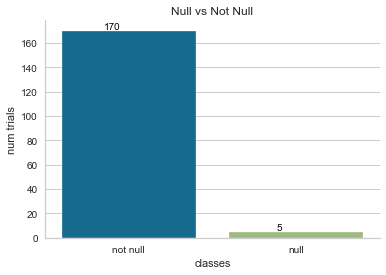

In [216]:
##############
# DISPLAY PREDICTED CLASS BALANCES
##############

# calculate values
total, not_null, num_reaches1, lr = num_trials_at_split
null = total-not_null
num_reaches2 = not_null-num_reaches1
lra_rla_bi = num_reaches1-lr

def visualize_classbalance(classNames, numTrials):
    """ Displays seaborn barchart of class balances.
    Args:
        classNames(list of str)
        numTrials(list int)
    """
    d = {'classes': classNames, 'num trials': numTrials}
    df = pd.DataFrame(data=d)

    graph = sns.barplot(x='classes', y = 'num trials', data=df)
    
    # display values (credit stack overflow)
    #     https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
    for p in graph.patches:
            graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                        ha='center', va='bottom',
                        color= 'black')
    return graph


visualize_classbalance(['not null', 'null'], [not_null, null]).set_title("Null vs Not Null");

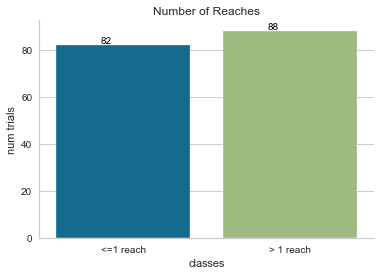

In [217]:
##############
# DISPLAY CLASS BALANCES
##############
visualize_classbalance(['<=1 reach', '> 1 reach'], [num_reaches1, num_reaches2]).set_title("Number of Reaches");

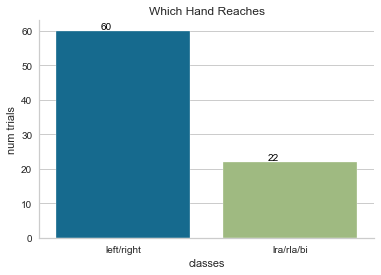

In [218]:
##############
# DISPLAY CLASS BALANCES
##############
visualize_classbalance(['left/right', 'lra/rla/bi'], [lr, lra_rla_bi]).set_title("Which Hand Reaches");

In [219]:
##############
# GENERATE DENDROGRAM
###############

# Import Tree instance and faces module
from ete3 import Tree, faces, TreeStyle

def create_dendrogram(scores, trained_models, preds, num_trials_at_split):
    """ Renders a dendrogram of classification hierarchy.
    Args:
        scores (list): accuracy scores for null, reach, hand 
        num_trials_at_split (list): [total, num trials classified as not null, <=1 num reaches, l/r]
        
    """
    
    # format scores
    scores = map(str, scores)
    scores = [val[0:4] for val in scores] # display 3 sig figs
    null_score, reach_score, hand_score = scores
    
    # calculate num trials at splits
    total, not_null, num_reaches1, lr = num_trials_at_split
    # calculate fraction
    total_frac = str(total)+'/'+str(total)
    not_null_frac = str(not_null)+'/'+str(total)
    num1_frac = str(num_reaches1)+'/'+str(not_null)
    lr_frac = str(lr)+'/'+str(num_reaches1)
    # calculate fraction of other class
    null_frac = str(total-not_null)+'/'+str(total)
    num2_frac = str(not_null-num_reaches1)+'/'+str(not_null)
    hand_bi_frac = str(num_reaches1-lr)+'/'+str(num_reaches1)
    
    # calculate percentage
    not_null_percent = not_null/total*100
    num1_percent = num_reaches1/not_null*100
    lr_percent = lr/num_reaches1*100
    # calc percentage of other class
    null_p = 100-not_null_percent
    num2_p = 100-num1_percent
    hand_bi_p = 100-lr_percent
    
    # format num trials at splits
    temp = [not_null_percent, num1_percent, lr_percent, null_p, num2_p, hand_bi_p]
    temp = [np.round(x, decimals=1) for x in temp] # round to 1 decimal place
    temp = map(str, temp)
    temp = ["("+val+'%'+")" for val in temp]
    not_null_percent, num1_percent, lr_percent, null_p, num2_p, hand_bi_p = temp
    
    #print(not_null_percent, num1_percent, lr_percent)
    #print(null_frac, num2_frac ,hand_bi_frac)
    #print(null_score)
      
    # Loads an example tree
    # change to change tree structure and branch length
    nw = """ (((>1 reach:0.5)2:2,
    ((right:3, left:3)7:6,(lra:2, bi:2, rla:2)6:7)5:3)2:2,
    Null Trial:1);
    """
    t = Tree(nw)

    # You can create any random tree containing the same leaf names, and
    # layout will work equally
    #
    # t = Tree()
    # Creates a random tree with 8 leaves using a given set of names


    # Set the path in which images are located
    img_path = "./"
    # Create faces based on external images
    example_image = faces.ImgFace(img_path+"ex_class_balance.PNG", width=500, height=500)


    # Create a faces ready to read the name attribute of nodes
    #nameFace = faces.TextFace(open("text").readline().strip(), fsize=20, fgcolor="#009000")
    nameFace = faces.AttrFace("name", fsize=20, fgcolor="#009000")

    # Create a conversion between leaf names and real names
    code2name = {
            "left":"",
            "right":"",
            ">1 reach": "\n trials="+num2_frac+" "+num2_p,
            "lra": "",
            "bi":"",
            "rla":"",
            "Null Trial": "\n trials="+null_frac+" "+null_p
            }

    # Creates a dictionary with the descriptions of each leaf name
    code2desc = {
            "right":"""Reach is right handed.""",
            "left":"""Reach is left handed.""",
            ">1 reach": """More than 1 reach.""",
            "Null Trial":"""Null trial.""",
                "lra":"""Left Right Assisted reach.""",
            "bi": """Bimanual reach.""",
            "rla":"""Right Left Assisted reach."""
            }


    # Creates my own layout function. I will use all previously created
    # faces and will set different node styles depending on the type of
    # node.
    def mylayout(node):
        # If node is a leaf, add the nodes name and a its scientific
        # name
        if node.is_leaf():

            # Add an static face that handles the node name
            faces.add_face_to_node(nameFace, node, column=0)

            # We can also create faces on the fly
            longNameFace = faces.TextFace(code2name[node.name])
            faces.add_face_to_node(longNameFace, node, column=0)

            # text faces support multiline. We add a text face
            # with the whole description of each leaf.
            descFace = faces.TextFace(code2desc[node.name], fsize=10)
            descFace.margin_top = 10
            descFace.margin_bottom = 10
            descFace.border.margin = 1

            # Note that this faces is added in "aligned" mode
            faces.add_face_to_node(descFace, node, column=0, aligned=True)

            # Sets the style of leaf nodes
            node.img_style["size"] = 12
            node.img_style["shape"] = "circle"

            if (node.name=='Null Trial'):
                # Modifies this node's style
                node.img_style["size"] = 16
                node.img_style["shape"] = "sphere"
                node.img_style["fgcolor"] = "#AA0000"

            if (node.name=='>1 reach'):
                # Modifies this node's style
                node.img_style["size"] = 16
                node.img_style["shape"] = "sphere"
                node.img_style["fgcolor"] = "#AA0000"


        #If node is an internal node
        else:

            # Sets the style of internal nodes
            node.img_style["size"] = 6
            node.img_style["shape"] = "circle"
            node.img_style["fgcolor"] = "#000000"


            #for name in node.get_leaf_names():
            #    print(node.get_leaf_names())


            # Add an text to nodes    
            if node.get_leaf_names() == ['>1 reach', 'right', 'left', 'lra', 'bi', 'rla', 'Null Trial']:
                    longNameFace = faces.TextFace("Null or Not Null Trial? \n trials="+total_frac+" (100%)"
                                                  +" \n score="+null_score
                                                  , fsize=12)
                    faces.add_face_to_node(longNameFace, node, column=0)
                    #faces.add_face_to_node(example_image, node, column=1) 

            if node.get_leaf_names() == ['>1 reach', 'right', 'left', 'lra', 'bi', 'rla']:
                    longNameFace = faces.TextFace("Not Null Trial \n trials="+not_null_frac+" "+not_null_percent+
                                                  "\n \n => Number of Reaches? \n score="+reach_score
                                                  , fsize=12)
                    faces.add_face_to_node(longNameFace, node, column=0)    

            if node.get_leaf_names() == ['right', 'left', 'lra', 'bi', 'rla']:
                    longNameFace = faces.TextFace("1 reach \n trials="+num1_frac+" "+num1_percent+
                                                  "\n \n=> Which Hand Reaches? \n score=" + hand_score
                                                  , fsize=12)
                    faces.add_face_to_node(longNameFace, node, column=0)

            if node.get_leaf_names() == ['right', 'left']: 
                    longNameFace = faces.TextFace("l/r \n trials="+lr_frac+" "+lr_percent, fsize=12)
                    faces.add_face_to_node(longNameFace, node, column=0)        

            if node.get_leaf_names() == ['lra', 'bi', 'rla']:
                    longNameFace = faces.TextFace('lra/bi/rla \n trials='+hand_bi_frac+" "+hand_bi_p, fsize=12)
                    faces.add_face_to_node(longNameFace, node, column=0)        


        # If an internal node contains more than 4 leaves, add the
        # images of the represented species sorted in columns of 2
        # images max.
        if len(node)>=4:
            col = 0
            for i, name in enumerate(set(node.get_leaf_names())):
                if i>0 and i%2 == 0:
                    col += 1

                # Modifies this node's style
                node.img_style["size"] = 16
                node.img_style["shape"] = "sphere"
                node.img_style["fgcolor"] = "#AA0000"


        # If leaf is "l/r" , highlight it using a
        # different background.
        #if node.is_leaf() and node.name.startswith("l/r"):
        #    node.img_style["bgcolor"] = "#9db0cf"

    # And, finally, Visualize the tree using my own layout function
    ts = TreeStyle()
    ts.layout_fn = mylayout

    t.show(tree_style=ts)
    #t.render(file_name="%%inline", w=600, tree_style = ts)
    
create_dendrogram(scores, trained_models, preds, num_trials_at_split)